In [ ]:
# ============================================================
# 📦 下載與整理資料集（OULAD）
# ============================================================

import kagglehub
import shutil
import os

# 1️⃣ 從 Kaggle Hub 下載最新版本資料集（自動快取）
path = kagglehub.dataset_download(
    "anlgrbz/student-demographics-online-education-dataoulad"
)
print("Path to dataset files:", path)

# 2️⃣ 指定搬移目的地
dest_dir = "./download_data"
os.makedirs(dest_dir, exist_ok=True)

# 3️⃣ 搬移所有 CSV 檔案到本地資料夾（方便統一存取）
for filename in os.listdir(path):
    src_file = os.path.join(path, filename)
    dest_file = os.path.join(dest_dir, filename)
    if os.path.isfile(src_file):
        shutil.copy2(src_file, dest_file)

print(f"✅ Dataset files moved to: {os.path.abspath(dest_dir)}")


/mnt/hgfs/shared_folder/summer_study/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/guoyouuu/.cache/kagglehub/datasets/anlgrbz/student-demographics-online-education-dataoulad/versions/1
✅ Dataset files moved to: /mnt/hgfs/shared_folder/summer_study/src/download_data


In [ ]:
import os
import random
import numpy as np
import torch

# ============================================================
# 🔧 全域設定（Global Settings）
# ============================================================
EPOCHS = 100
SEED = 42

# 啟用多核心（最多 16 threads）
torch.set_num_threads(min(16, os.cpu_count() or 1))
print(f"使用 CPU threads: {torch.get_num_threads()}")

# 固定隨機種子（確保結果可重現）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# 裝置設定（自動偵測 GPU / CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用裝置:", device)
print(f"PyTorch 版本: {torch.__version__}")

# ============================================================
# ⚙️ 模型與資料參數設定
# ============================================================
T_IN, T_OUT = 4, 2           # Encoder/Decoder 時間長度
HIDDEN_DIM, NUM_LAYERS = 64, 1
LATENT_DIM = 16               # VAE 潛在維度
LR, BATCH_SIZE = 1e-3, 128
BETA, TEACHER_FORCING = 2, 0.5
VAE_SAMPLE_N, COVERAGE_ALPHA = 20, 1.0

# 特徵設定
FEATURES = ["clicks", "submit_cnt", "has_submit", "avg_score_sofar", "clicks_diff1"]
CONT_FEATURES = ["clicks", "submit_cnt", "avg_score_sofar", "clicks_diff1"]
BIN_FEATURES = ["has_submit"]
D_IN = len(FEATURES)



使用 CPU threads: 16
使用裝置: cpu
PyTorch 版本: 2.8.0+cu128


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# 🧱 1) 讀取原始資料
#   - 三個來源：學生靜態資料、線上學習點擊紀錄、作業成績/提交
# ============================================================
PATH_INFO   = "./download_data/studentInfo.csv"
PATH_VLE    = "./download_data/studentVle.csv"
PATH_ASSESS = "./download_data/studentAssessment.csv"

info = pd.read_csv(PATH_INFO)
vle  = pd.read_csv(PATH_VLE)
ass  = pd.read_csv(PATH_ASSESS)

# ============================================================
# 🧩 2) 補齊欄位 / 清理日期
#   - assessment 檔沒有 module/presentation → 從 info 依 id_student 補上
#   - 移除 date<0：避免產生負週數（課程前的系統記錄不納入）
# ============================================================
ass = ass.merge(
    info[["code_module", "code_presentation", "id_student"]],
    on="id_student", how="left"
)
vle = vle[vle["date"] >= 0].copy()
ass = ass[ass["date_submitted"] >= 0].copy()

# ============================================================
# 📆 3) 轉成「週」為時間單位
#   - OULAD 的 date 為課程日數（從開課日 0 起算），以 //7 壓成週
#   - 好處：降噪、與作業 T_IN=4 / T_OUT=2 的週級預測尺度一致
# ============================================================
vle["week"] = (vle["date"] // 7).astype(int)
ass["week"] = (ass["date_submitted"] // 7).astype(int)

# ============================================================
# 📊 4) 週級特徵聚合
#   (a) clicks：同一學生/週的 sum_click 加總
#   (b) submit_cnt / has_submit：該週提交作業次數與是否有提交
#   (c) avg_score_sofar：至該週的「累積平均分數」（考慮時間順序）
# ============================================================

# (a) 每週點擊數
clicks_w = (
    vle.groupby(["code_module","code_presentation","id_student","week"])["sum_click"]
       .sum()
       .rename("clicks")
       .reset_index()
)

# (b) 每週提交次數與是否提交（>0）
ass_w = (
    ass.groupby(["code_module","code_presentation","id_student","week"])["id_assessment"]
       .count()
       .rename("submit_cnt")
       .reset_index()
)
ass_w["has_submit"] = (ass_w["submit_cnt"] > 0).astype(int)

# (c) 累積平均分數：先依時間排序 → 再做個別學生的累積 mean
ass_sc = ass.dropna(subset=["score"]).copy()
ass_sc.sort_values(["code_module","code_presentation","id_student","week"], inplace=True)
ass_sc["cum_sum"] = ass_sc.groupby(["code_module","code_presentation","id_student"])["score"].cumsum()
ass_sc["cum_cnt"] = ass_sc.groupby(["code_module","code_presentation","id_student"])["score"].cumcount() + 1
ass_sc["avg_score_sofar"] = ass_sc["cum_sum"] / ass_sc["cum_cnt"]

# 取到「每週的最後一次可用平均」當週值（避免同週多次提交重複）
score_w = (
    ass_sc.groupby(["code_module","code_presentation","id_student","week"])["avg_score_sofar"]
          .last()
          .reset_index()
)

# ============================================================
# 🔗 5) 合併特徵到週級面板 (panel)
#   - 左連 info：保留所有學生基本資料（某些週沒有 clicks/submit 也不丟）
#   - 再左連 clicks/submit/score
#   - 缺值處理：
#       clicks, submit_cnt: 0（未點擊/未提交）
#       has_submit: 0（布林）
#       avg_score_sofar: 以學生為單位 ffill（開頭仍缺就填 0）
# ============================================================
weekly = info.merge(clicks_w, on=["code_module","code_presentation","id_student"], how="left")
weekly = weekly.merge(ass_w,   on=["code_module","code_presentation","id_student","week"], how="left")
weekly = weekly.merge(score_w, on=["code_module","code_presentation","id_student","week"], how="left")

weekly["clicks"]      = weekly["clicks"].fillna(0.0)
weekly["submit_cnt"]  = weekly["submit_cnt"].fillna(0.0)
weekly["has_submit"]  = weekly["has_submit"].fillna(0).astype(int)
weekly["avg_score_sofar"] = (
    weekly.groupby(["code_module","code_presentation","id_student"])["avg_score_sofar"]
          .ffill()           # 只在「同一學生」內向前帶
          .fillna(0.0)       # 人生第一筆仍沒有分數 → 0
)

# ============================================================
# 🧮 6) 補齊每位學生的「連續週」索引，並做一階差分
#   - 有些學生某些週完全沒行為 → 需要補 0 讓序列連續
#   - clicks_diff1: 一階差分（動量/加速度訊號），供模型學習變化率
#   - 只保留長度 >= T_IN + T_OUT 的學生（夠切片才能抽樣訓練）
# ============================================================
def build_student_week_table(df):
    df = df.dropna(subset=["week"])
    if len(df) == 0:
        return pd.DataFrame(columns=["week","clicks","submit_cnt","has_submit","avg_score_sofar","clicks_diff1"])

    wmin, wmax = int(df["week"].min()), int(df["week"].max())
    # 生成連續週索引後左連，缺的填 0
    full = pd.DataFrame({"week": np.arange(wmin, wmax + 1, dtype=int)})
    full = full.merge(
        df[["week","clicks","submit_cnt","has_submit","avg_score_sofar"]],
        on="week", how="left"
    ).fillna(0.0)

    # 週點擊的一階差分（第 1 週差分定義為 0）
    full["clicks_diff1"] = full["clicks"].diff().fillna(0.0)
    return full.reset_index(drop=True)

grp_keys = ["code_module","code_presentation","id_student"]
student_tables = {}
for k, g in weekly.groupby(grp_keys, sort=False):
    tbl = build_student_week_table(g)
    if len(tbl) >= (T_IN + T_OUT):
        student_tables[k] = tbl

print(f"✅ 共 {len(student_tables)} 位學生具足夠週數資料")


✅ 共 25146 位學生具足夠週數資料


In [ ]:
from sklearn.model_selection import train_test_split

# ============================================================
# 🧭 1. 資料切分（Train / Val / Test）
# ============================================================
# train : val : test ≈ 70 : 15 : 15
ids = list(student_tables.keys())
train_ids, test_ids = train_test_split(ids, test_size=0.15, random_state=SEED)
train_ids, val_ids  = train_test_split(train_ids, test_size=0.1765, random_state=SEED)
print(f"train/val/test = {len(train_ids)}/{len(val_ids)}/{len(test_ids)}")

# ============================================================
# ⚖️ 2. 以訓練集統計量進行標準化（Standardization）
# ============================================================
def fit_transform_standardize(student_tables, train_ids, cont_cols):
    """
    以 train set 的學生資料估計各連續特徵的 μ / σ，
    並對所有學生的特徵（含驗證與測試）做標準化。
    """
    # 收集所有訓練學生的連續欄位
    train_concat = pd.concat([student_tables[k][cont_cols] for k in train_ids], axis=0)
    mu = train_concat.mean(axis=0)
    sd = train_concat.std(axis=0).replace(0, 1e-8)  # 防止除以零

    # 套用 (x - μ) / σ 轉換到所有學生
    for k in student_tables:
        for col in cont_cols:
            student_tables[k][col] = (student_tables[k][col] - mu[col]) / sd[col]
    return mu.to_dict(), sd.to_dict()

# 執行標準化（並保留 clicks 的 μ、σ 以便後續反標準化）
mu, sd = fit_transform_standardize(student_tables, train_ids, CONT_FEATURES)
CLICK_MU, CLICK_SD = mu["clicks"], sd["clicks"]

print("✅ 標準化完成（以 train 為基準；後續評估會反標準化 clicks）")


train/val/test = 17601/3773/3772
✅ 標準化完成（以 train 為基準；後續評估會反標準化 clicks）


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# ============================================================
# 📦 自訂 Dataset：建立 (X, Y) 時間序列樣本
# ============================================================
class StudentSeqDataset(Dataset):
    def __init__(self, student_tables, ids, T_IN, T_OUT, features):
        """
        student_tables : dict，每位學生的 weekly 特徵資料表
        ids : list，包含該資料集（train/val/test）的學生索引鍵
        T_IN : int，輸入序列長度（Encoder 使用的過去週數）
        T_OUT : int，輸出序列長度（Decoder 預測的未來週數）
        features : list[str]，作為模型輸入的欄位名稱
        """
        self.samples = []
        for sid in ids:
            tbl = student_tables[sid]
            x_all = tbl[features].values.astype(np.float32)                 # (W, D_IN)
            y_all = tbl["clicks"].values.astype(np.float32).reshape(-1, 1)  # (W, 1)
            W = len(tbl)

            # 建立滑動視窗樣本：每個學生的序列都會生成多筆 (X, Y)
            for t in range(T_IN - 1, W - T_OUT):
                x = x_all[t - T_IN + 1 : t + 1]       # Encoder 輸入：過去 T_IN 週
                y = y_all[t + 1 : t + 1 + T_OUT]     # Decoder 輸出：未來 T_OUT 週
                self.samples.append((x, y))

    def __len__(self):
        """回傳樣本總數（所有學生展開後的數量）"""
        return len(self.samples)

    def __getitem__(self, idx):
        """取出第 idx 筆樣本，轉為 torch.Tensor"""
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ============================================================
# 🔄 建立 Dataset 與 DataLoader
# ============================================================
train_ds = StudentSeqDataset(student_tables, train_ids, T_IN, T_OUT, FEATURES)
val_ds   = StudentSeqDataset(student_tables, val_ids,   T_IN, T_OUT, FEATURES)
test_ds  = StudentSeqDataset(student_tables, test_ids,  T_IN, T_OUT, FEATURES)

# DataLoader：負責 batch 化與 shuffle
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


Train: 428270 | Val: 91664 | Test: 91566


# Seq2Seq LSTM 邏輯流程（模型詳解版）

---

## 1. 問題背景

* **任務目標**：時間序列預測（Sequence-to-Sequence Prediction）。
  模型觀察過去一段時間的行為序列，學習其中的變化規律，
  進而預測未來一段時間的行為走向。

* **應用場景**：
  我們使用學生在學習平台上的行為資料作為例子。
  模型輸入：

  * 過去 **4 週** 的特徵（如 clicks、作業數、平均分數等）
    模型輸出：
  * 未來 **2 週** 的 `clicks` 預測值。

* **核心思想**：
  傳統的 RNN 難以記住長期關係（會「遺忘前幾週」），
  而 LSTM（長短期記憶）能同時保留短期與長期資訊。
  在 **Seq2Seq 架構** 中，我們把 LSTM 拆成兩部分：

  * **Encoder**：專門「讀取過去」
  * **Decoder**：專門「生成未來」

---

## 2. 資料流與維度

### 輸入與輸出

| 名稱                     | 意義             | 張量形狀                |
| ---------------------- | -------------- | ------------------- |
| **Encoder input (X)**  | 過去 4 週的所有特徵    | (B, T_in=4, D_in=5) |
| **Decoder output (Y)** | 未來 2 週的 clicks | (B, T_out=2, 1)     |

其中：

* **B**：一次訓練批次中有多少學生
* **T_in**：輸入時間長度（4 週）
* **D_in**：每週特徵數（5 個）
* **T_out**：要預測的時間長度（2 週）

範例：

> 對某個學生來說，模型輸入：
>
> ```
> 第1週: [clicks=50, submit=1, has_submit=1, avg_score=60, diff=0]
> 第2週: [clicks=40, submit=0, has_submit=0, avg_score=60, diff=-10]
> 第3週: [clicks=80, submit=2, has_submit=1, avg_score=70, diff=40]
> 第4週: [clicks=100, submit=1, has_submit=1, avg_score=75, diff=20]
> ```
>
> 模型要預測：
>
> ```
> 第5週、第6週的 clicks 數。
> ```

---

## 3. 模型結構

Seq2Seq LSTM 由兩個主要部分組成：

---

### (1) Encoder：讀取與壓縮過去資訊

**輸入：**
一段時間序列 (B, T_in, D_in)。

**結構與運作：**

```python
h_t, c_t = LSTMEncoder(x)
```

* Encoder 使用一個 LSTM 層（或多層）。
* 它會逐週讀取輸入資料，更新內部狀態。
* LSTM 在每一步維持兩個重要變數：

  * **h_t（hidden state）**：即時的理解，像「短期記憶」
  * **c_t（cell state）**：長期的背景資訊，像「長期記憶」

經過最後一週之後，我們只取出最終的 `(h_T, c_T)`，作為整段「過去行為」的壓縮表示。

舉例：

> 假設學生第 1~4 週的行為差異很大，
> Encoder 會在第 4 週後得到一個「綜合向量」，
> 這個向量就像模型的理解：
> 「這個學生從不活躍 → 突然變得非常活躍」。

---

### (2) Decoder：根據記憶生成未來

**輸入：**

* Encoder 的最終狀態 `(h_T, c_T)`
* 過去最後一週的 clicks（即 `y_0`）

**結構與運作：**

```python
y_hat = LSTMDecoder(y0, h, c, T_OUT)
```

Decoder 也使用 LSTM，但角色不同：

* 它不再「讀取輸入」，而是「產生輸出」。
* 每次會用前一週的 clicks（真實或預測）作為輸入，預測下一週的 clicks。

具體步驟：

1. 初始輸入：

   ```python
   y_t = x[:, -1, 0]  # 最後一週的 clicks
   ```
2. 每步更新：

   ```
   (h, c) = LSTM(y_t, (h, c))
   y_hat_t = Linear(h)
   ```
3. 下一步輸入：

   * 若使用 teacher forcing：`y_t = y_true_t`
   * 否則：`y_t = y_hat_t`

如此重複直到生成 `T_out=2` 週的預測。

> **重點**：Decoder 並非一次輸出兩週，而是「一週一週」地預測，
> 每次都根據前一步的結果更新內部狀態。
> 這讓模型能捕捉到「未來行為的連續性」。

---

## 4. 損失函數

使用 **MSE (Mean Squared Error)** 衡量預測值與真實值的誤差。

$$
L_{MSE} = \frac{1}{T_{out}} \sum_{t=1}^{T_{out}} (y_t - \hat{y_t})^2
$$

例如：

| 時間         | 真實 clicks | 預測 clicks | 誤差平方                  |
| ---------- | --------- | --------- | --------------------- |
| 第5週        | 120       | 110       | (120-110)² = 100      |
| 第6週        | 150       | 160       | (150-160)² = 100      |
| **平均 MSE** |           |           | **(100+100)/2 = 100** |

---

## 5. 訓練步驟（每個 batch）

1. **前向傳遞**

   ```python
   Y_hat = model(X, y_teacher=Y, tf_ratio=0.5)
   ```

   * `tf_ratio` 控制 Teacher Forcing 比例。
   * 模型一邊用真實值，一邊用自己預測的值訓練。

2. **計算損失**

   ```python
   loss = mse_loss(Y_hat, Y)
   ```

3. **反向傳遞與更新**

   ```python
   opt.zero_grad()
   loss.backward()
   opt.step()
   ```

4. **驗證集評估**
   使用相同流程，但不使用 Teacher Forcing (`tf_ratio=0`)。

---

## 6. 整體邏輯摘要

| 元件                  | 主要任務                               | 資料流                   |
| ------------------- | ---------------------------------- | --------------------- |
| **Encoder**         | 讀取過去 4 週的特徵，提取最終狀態 (h_T, c_T)      | X → LSTM → (h_T, c_T) |
| **Decoder**         | 以 (h_T, c_T) 為起點，逐步預測未來 2 週 clicks | y₀ → LSTM → ŷ₁ → ŷ₂ |
| **Loss (MSE)**      | 最小化預測與真實 clicks 的平均平方誤差            | (ŷ - y)²             |
| **Teacher Forcing** | 訓練時混合使用真實值與預測值，幫助模型收斂              | tf_ratio=0.5          |
| **結果**              | 模型能穩定預測短期趨勢，但每次輸出唯一結果（確定性）。        | 單一路徑預測                |

---

📘 **直覺理解：**

> 你可以想像整個模型像是一個「會預測的老師」：
>
> * Encoder：先讀學生的學習歷程（過去 4 週）
> * Decoder：根據這些記憶，每週猜他未來會多活躍
> * MSE：檢查他猜的準不準，再修正想法

---



In [ ]:
import torch
import torch.nn as nn
import random

# ============================================================
# 🧩 Seq2Seq LSTM 模型架構
# ============================================================

class LSTMEncoder(nn.Module):
    """
    🔹 功能：讀取過去 T_IN 週的特徵序列 (x1, x2, ..., x_TIN)
    🔹 輸出：最終的隱藏狀態 (h_T, c_T)，提供給 Decoder 作為初始條件。
    """
    def __init__(self, d_in: int, hidden: int, num_layers: int = 1):
        super().__init__()
        # batch_first=True → 輸入維度為 (B, T, D)
        self.lstm = nn.LSTM(d_in, hidden, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        # x: (B, T_IN, D_IN)
        _, (h, c) = self.lstm(x)
        # h, c: (num_layers, B, hidden)
        return h, c


class LSTMDecoder(nn.Module):
    """
    🔹 功能：根據初始隱藏狀態 (h, c) 與初始輸入 y0，
             逐步預測未來 T_OUT 週的 clicks。
    🔹 特點：支援 teacher forcing 機制，加速模型收斂。
    """
    def __init__(self, hidden: int, num_layers: int = 1, d_out: int = 1):
        super().__init__()
        # Decoder 以上一週的預測值作為下一週的輸入
        self.lstm = nn.LSTM(d_out, hidden, num_layers=num_layers, batch_first=True)
        # 將 LSTM 輸出轉回實際預測值（clicks）
        self.proj = nn.Linear(hidden, d_out)

    def forward(self, y0, h, c, T_OUT: int, teacher=None, tf_ratio: float = 0.0):
        """
        y0: 初始輸入 (通常為 x 的最後一週 clicks)
        teacher: 真實未來 clicks（在訓練時使用）
        tf_ratio: Teacher Forcing 機率
        """
        outs, y_t = [], y0
        for t in range(T_OUT):
            # 將目前週的輸入 y_t 餵進 LSTM
            out, (h, c) = self.lstm(y_t, (h, c))
            # 投影回實際輸出空間
            y_hat = self.proj(out)
            outs.append(y_hat)

            # --- Teacher Forcing 機制 ---
            # 在訓練階段，有 tf_ratio 機率用真實值取代模型預測作為下一步輸入
            if (teacher is not None) and (random.random() < tf_ratio):
                y_t = teacher[:, t:t+1, :]  # 使用真實輸出
            else:
                y_t = y_hat                 # 使用模型預測值

        # 最終輸出序列 (B, T_OUT, 1)
        return torch.cat(outs, dim=1)


class Seq2SeqLSTM(nn.Module):
    """
    🔹 功能：整合 Encoder + Decoder，形成完整 Seq2Seq 結構。
    🔹 用於單一路徑預測（deterministic）。
    """
    def __init__(self, d_in, hidden, num_layers, T_OUT):
        super().__init__()
        self.enc = LSTMEncoder(d_in, hidden, num_layers)
        self.dec = LSTMDecoder(hidden, num_layers, d_out=1)
        self.T_OUT = T_OUT

    def forward(self, x, y_teacher=None, tf_ratio: float = 0.0):
        # Encoder：讀入過去特徵 → 隱藏狀態
        h, c = self.enc(x)
        # Decoder 初始輸入 y0 = 最後一週 clicks（與標準化尺度一致）
        y0 = x[:, -1, 0].view(-1, 1, 1)
        # 逐步生成未來序列
        return self.dec(y0, h, c, self.T_OUT, teacher=y_teacher, tf_ratio=tf_ratio)



# Seq2Seq VAE 邏輯流程（模型詳解版）

---

## 1. 問題背景

* **任務目標**：同樣是序列預測（Sequence-to-Sequence Prediction），但這次我們希望模型能表達「不確定性」。

* **動機：為什麼要從 LSTM 改成 VAE？**

  * LSTM 的輸出是「確定的」（deterministic）。
    ➜ 給同一個輸入，永遠輸出同一條預測路徑。
  * 但真實世界的行為（例如學生學習活躍度、股價、氣候）具有「多種可能未來」。
    ➜ 有些學生可能繼續努力，也可能突然懶散。
  * 因此我們希望模型能學會「未來的多樣性」，
    這時就要引入 **Variational Autoencoder (VAE)** 的概念。

* **核心概念：**

  * Encoder 不再只輸出一個固定的向量，而是學會「一個分布」。
  * 我們從這個分布中「隨機抽樣潛在變數 (latent variable) `z`」，
    代表不同的未來可能性。
  * Decoder 再根據這個 `z` 生成不同版本的未來 clicks。
  * 如此一來，模型可以在保持現實合理的前提下，輸出多條可能的預測曲線。

---

## 2. 資料流與維度

### 輸入輸出定義

| 名稱                      | 說明              | 張量形狀                |
| ----------------------- | --------------- | ------------------- |
| **Encoder input (X)**   | 過去 4 週的特徵       | (B, T_in=4, D_in=5) |
| **Decoder output (Y)**  | 未來 2 週的 clicks  | (B, T_out=2, 1)     |
| **Latent variable (z)** | 壓縮的隱含特徵（不同未來情境） | (B, z_dim=8 或 16)   |

其中：

* `B`：批次大小（batch size）
* `T_in`：Encoder 觀察的週數（4）
* `T_out`：Decoder 要生成的週數（2）
* `D_in`：每週輸入特徵（5）
* `z_dim`：潛在空間維度（latent dimension）

---

## 3. 模型結構（Encoder + Decoder + 取樣）

Seq2Seq VAE 由三部分組成：

---

### (1) VAE Encoder：學習「未來可能性的分布」

**輸入：**
過去 4 週的特徵序列 $(B, T_{in}, D_{in})$

**結構：**

```python
self.lstm = nn.LSTM(D_in, hidden, ...)
self.mu = nn.Linear(hidden, z_dim)
self.logvar = nn.Linear(hidden, z_dim)
```

**運作流程：**

1. 將輸入序列餵入 LSTM，最終取出最後時間步的隱藏狀態 `h_T`。

   * 這代表「模型對學生整體學習趨勢的理解」。
2. 透過兩個全連接層，分別輸出：

   * `μ (mu)`：潛在分布的平均
   * `logσ² (logvar)`：潛在分布的變異

這樣模型不再輸出單一向量，而是：
$$
z \sim \mathcal{N}(\mu, \sigma^2)
$$

**直覺理解：**
如果學生學習行為穩定，則模型會輸出較小的變異 → 未來趨勢明確。
反之若行為波動大，模型會輸出較大的變異 → 未來存在更多可能性。

---

### (2) Reparameterization Trick：可導的隨機取樣

在訓練神經網路時，不能直接從分布抽樣（會導致梯度無法反傳），
因此我們用以下方法「可微分地取樣」：

$$
z = \mu + \epsilon \cdot \exp(0.5 \cdot \text{logvar}), \quad \epsilon \sim \mathcal{N}(0, I)
$$

對應程式：

```python
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps
```

這樣模型既能學到分布參數，也能讓梯度順利反傳。

---

### (3) VAE Decoder：根據潛變量生成未來序列

**輸入：**

* 潛在向量 `z`（代表一種可能的未來）
* 起始 clicks 值 `y_0`（過去最後一週）
* 輸出時間長度 `T_out`

**結構：**

```python
self.init_h = nn.Linear(z_dim, hidden)
self.init_c = nn.Linear(z_dim, hidden)
self.lstm = nn.LSTM(1, hidden, ...)
self.proj = nn.Linear(hidden, 1)
```

**運作流程：**

1. 使用兩個線性層將 `z` 轉換成初始的 LSTM 狀態：

   * `h_0 = tanh(W_h * z)`
   * `c_0 = tanh(W_c * z)`
2. 從 `y_0` 開始逐步生成未來 2 週的 clicks：

   ```
   for t in range(T_OUT):
       out, (h, c) = LSTM(y_t, (h, c))
       y_hat_t = Linear(out)
       y_t = y_hat_t
   ```
3. 最終輸出形狀為 `(B, T_OUT, 1)`。

**直覺理解：**

> 每一個潛變量 z 都代表「一個潛在的未來走向」。
> 例如：
>
> * z₁ → 積極型學生（clicks 逐步上升）
> * z₂ → 懶散型學生（clicks 下滑）
> * z₃ → 不穩定型學生（clicks 波動）

---

## 4. 損失函數（VAE 的核心）

VAE 的訓練同時包含兩部分：

### (1) 重建誤差（Reconstruction Loss）

確保模型生成的結果與真實值接近。

$$
L_{rec} = \frac{1}{T_{out}} \sum (y_t - \hat{y_t})^2
$$

對應程式：

```python
rec = ((y_hat - y) ** 2).mean()
```

---

### (2) KL 散度（Kullback-Leibler Divergence）

鼓勵潛變量的分布接近標準常態分布 $\mathcal{N}(0, I)$，
避免模型記太死，讓 `z` 的生成更平滑有意義。

$$
L_{KL} = -\frac{1}{2} \sum(1 + \log\sigma^2 - \mu^2 - \sigma^2)
$$

對應程式：

```python
kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
```

---

### (3) 結合損失（β-VAE）

總損失為：
$$
L_{total} = L_{rec} + \beta \cdot L_{KL}
$$

其中：

* **β（beta）** 控制「生成品質 vs 多樣性」的權衡。

  * β 大 → 強調分布正則化（樣本差異小但穩定）
  * β 小 → 強調重建準確（誤差小但樣本趨同）

---

## 5. 訓練步驟（每個 batch）

1. **前向傳遞**

   ```python
   y_hat, mu, logvar = model(X)
   loss, rec, kl = vae_loss(y_hat, Y, mu, logvar, beta)
   ```

   * Encoder 產生分布參數 (`mu`, `logvar`)
   * Reparameterization 取樣 z
   * Decoder 根據 z 生成未來 clicks
   * 計算兩種損失 (reconstruction + KL)

2. **反向傳遞**

   ```python
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   ```

3. **驗證階段**

   * 不取樣梯度，重複生成流程計算平均 loss。
   * 保存最優模型參數。

---

## 6. 整體邏輯摘要

| 組件                     | 功能                           | 資料流                      |
| ---------------------- | ---------------------------- | ------------------------ |
| **VAE Encoder**        | 讀取過去序列，輸出潛在分布參數 `(μ, logσ²)` | X → LSTM → (μ, logvar)   |
| **Reparameterization** | 從分布中隨機取樣潛變量 z                | z = μ + εσ               |
| **VAE Decoder**        | 根據 z 生成未來序列                  | (z, y₀) → LSTM → ŷ₁…ŷ₂ |
| **Loss**               | 綜合重建誤差與 KL 散度                | L = rec + β·KL           |
| **結果**                 | 模型能生成多條不同的未來曲線，反映真實世界的不確定性   | 多樣化預測 (diversity)        |

---

## 7. 模型直覺（視覺理解）

可以把 Seq2Seq VAE 想成「有想像力的預測者」：

```
Encoder：分析學生過去的學習行為
     ↓
潛變量 z：想像未來的不同情境（樂觀 / 保守 / 懶散）
     ↓
Decoder：根據 z 逐步預測未來 clicks
```

這使得：

* 模型不再只輸出「一條預測曲線」，
* 而是能產生「多條合理但不同的可能未來」。

---

## 8. 與 Seq2Seq LSTM 的對照

| 面向         | Seq2Seq LSTM        | Seq2Seq VAE                  |
| ---------- | ------------------- | ---------------------------- |
| 模型性質       | 確定性 (Deterministic) | 機率性 (Probabilistic)          |
| Encoder 輸出 | 單一向量 (h, c)         | 分布參數 (μ, logσ²)              |
| Decoder 輸入 | 固定記憶狀態              | 潛變量 z                        |
| 可生成樣本數     | 1 條預測               | 多條樣本路徑                       |
| 損失函數       | MSE                 | MSE + β·KL                   |
| 適用場景       | 想要單一路徑的穩定預測         | 想模擬「多種未來可能性」                 |
| 可評估指標      | MSE                 | Best-of-N、Diversity、Coverage |

---

📘 **直覺比喻：**

> * LSTM 就像「一個嚴謹的老師」：只會給出一個標準答案。
> * VAE 則像「一個懂得思考的預測者」：
>   會根據不同假設，想像多種未來情境，
>   並從中學到「什麼樣的未來是合理的」。

---


In [ ]:
import torch
import torch.nn as nn
import random

# ============================================================
# 🧠 Seq2Seq VAE 模型架構
# ============================================================

class VAEEncoder(nn.Module):
    """
    🔹 功能：讀取過去 T_IN 週序列 → 壓縮為潛在分布參數 (μ, logσ²)
    🔹 輸出：兩個張量 (mu, logvar)，定義近似的後驗分布 q(z|x)
    """
    def __init__(self, d_in, hidden, num_layers, z_dim):
        super().__init__()
        self.lstm = nn.LSTM(d_in, hidden, num_layers=num_layers, batch_first=True)
        self.mu = nn.Linear(hidden, z_dim)
        self.logvar = nn.Linear(hidden, z_dim)

    def forward(self, x):
        # 取 Encoder 最後一層的隱藏狀態
        _, (h, _) = self.lstm(x)
        h_last = h[-1]  # 取最上層 hidden state (B, hidden)
        return self.mu(h_last), self.logvar(h_last)  # (B, z_dim), (B, z_dim)


def reparameterize(mu, logvar):
    """
    🔹 Reparameterization Trick：
       將隨機取樣 z ~ N(μ, σ²) 改寫為可微形式 z = μ + σ * ε，
       使隨機過程可被反向傳遞梯度。
    """
    std = torch.exp(0.5 * logvar)  # σ = exp(½ logσ²)
    eps = torch.randn_like(std)    # ε ~ N(0, I)
    return mu + std * eps          # z = μ + σ * ε


class VAEDecoder(nn.Module):
    """
    🔹 功能：根據潛在變數 z → 生成未來 T_OUT 週的 clicks。
    🔹 步驟：
        1. 將 z 經過線性層映射成初始 LSTM 狀態 (h0, c0)
        2. 從初始輸入 y0 開始逐步生成序列
    """
    def __init__(self, z_dim, hidden, num_layers, d_out=1):
        super().__init__()
        # 將 latent vector z 投影為 LSTM 初始狀態
        self.init_h = nn.Linear(z_dim, hidden)
        self.init_c = nn.Linear(z_dim, hidden)
        self.lstm = nn.LSTM(d_out, hidden, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(hidden, d_out)

    def forward(self, z, T_OUT, y0):
        # 將 z 轉為初始隱藏狀態 (使用 tanh 限制範圍)
        h0 = torch.tanh(self.init_h(z)).unsqueeze(0)
        c0 = torch.tanh(self.init_c(z)).unsqueeze(0)
        outs, y_t, h, c = [], y0, h0, c0
        for t in range(T_OUT):
            # 每一步根據上一週 y_t 生成下一週
            out, (h, c) = self.lstm(y_t, (h, c))
            y_hat = self.proj(out)
            outs.append(y_hat)
            # 下一週的輸入為模型剛生成的 y_hat
            y_t = y_hat
        # (B, T_OUT, 1)
        return torch.cat(outs, dim=1)


class Seq2SeqVAE(nn.Module):
    """
    🔹 整體結構：
       Encoder (μ, logσ²) → Reparameterization → Decoder
    🔹 可生成多樣化未來序列（非單一確定輸出）
    """
    def __init__(self, d_in, hidden, num_layers, z_dim, T_OUT):
        super().__init__()
        self.enc = VAEEncoder(d_in, hidden, num_layers, z_dim)
        self.dec = VAEDecoder(z_dim, hidden, num_layers, d_out=1)
        self.T_OUT = T_OUT

    def forward(self, x):
        # Step 1. 編碼過去序列 → 得到 μ, logσ²
        mu, logvar = self.enc(x)
        # Step 2. 透過 reparameterization 抽樣潛在向量 z
        z = reparameterize(mu, logvar)
        # Step 3. 以最後一週 clicks 作為初始輸入
        y0 = x[:, -1, 0].view(-1, 1, 1)
        # Step 4. Decoder 由 z 生成未來 T_OUT 週預測
        y_hat = self.dec(z, self.T_OUT, y0)
        return y_hat, mu, logvar


In [ ]:
import torch
import torch.nn as nn

# ============================================================
# 📏 1. 基礎損失函數
# ============================================================

def mse_loss(pred, target):
    """
    🔹 功能：最基本的 MSE 損失，用於 LSTM 訓練階段
    🔹 注意：此處 pred / target 都是「標準化空間」的 clicks
    """
    return ((pred - target) ** 2).mean()


# ============================================================
# 🧩 2. LSTM 訓練流程
# ============================================================

def train_lstm(model, train_loader, val_loader, epochs, lr, tf_ratio):
    """
    🔹 功能：訓練 Seq2Seq LSTM 模型
    🔹 特點：
        - 使用 Teacher Forcing（部分步驟用真實輸入）
        - 追蹤 validation loss 以保留最佳權重
    """
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val, best_state = float("inf"), None  # early stopping 基準

    for ep in range(1, epochs + 1):
        # ---- Training phase ----
        model.train()
        tr_sum = 0.0
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)

            # 前向傳遞（含 Teacher Forcing）
            Y_hat = model(X, y_teacher=Y, tf_ratio=tf_ratio)

            # 計算 MSE 損失
            loss = mse_loss(Y_hat, Y)

            # 反向傳遞與更新
            opt.zero_grad()
            loss.backward()
            opt.step()

            tr_sum += loss.item() * X.size(0)

        # 計算平均訓練損失
        tr_loss = tr_sum / len(train_loader.dataset)

        # ---- Validation phase ----
        model.eval()
        va_sum = 0.0
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                # 驗證階段不使用 teacher forcing（純預測）
                Y_hat = model(X, y_teacher=None, tf_ratio=0.0)
                va_sum += mse_loss(Y_hat, Y).item() * X.size(0)
        va_loss = va_sum / len(val_loader.dataset)

        # ---- Early Stopping ----
        if va_loss < best_val:
            best_val = va_loss
            # detach + clone 避免 GPU memory reference
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        # ---- Log ----
        if ep % 1 == 0:
            print(f"[LSTM] Epoch {ep:02d} | train {tr_loss:.4f} | val {va_loss:.4f}")

    # 載入最佳權重
    model.load_state_dict(best_state)
    return model


# ============================================================
# 🧠 3. VAE 損失函數
# ============================================================

def vae_loss(y_hat, y, mu, logvar, beta):
    """
    🔹 功能：計算 VAE 的整體 loss
    🔹 組成：
        L = Reconstruction Loss + β * KL Divergence

        Reconstruction Loss：衡量生成序列與真實序列的誤差
        KL Divergence：限制潛在空間分布接近 N(0,1)
    🔹 β：控制生成多樣性與穩定性的權重
    """
    # 重建誤差 (Reconstruction)
    rec = ((y_hat - y) ** 2).mean()

    # KL Divergence：推使 q(z|x) 接近標準常態分布
    # KL = -0.5 * Σ (1 + logσ² - μ² - σ²)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # 加權組合
    return rec + beta * kl, rec, kl


# ============================================================
# 🚀 4. VAE 訓練流程
# ============================================================

def train_vae(model, train_loader, val_loader, epochs, lr, beta):
    """
    🔹 功能：訓練 Seq2Seq VAE 模型
    🔹 特點：
        - 同時最小化重建誤差與 KL Divergence
        - 控制 β 調整 latent 壓縮與生成多樣性
        - 保留 validation loss 最小的最佳模型
    """
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val, best_state = float("inf"), None

    for ep in range(1, epochs + 1):
        # ---- Warm-up β（指數式）----
        warmup_epochs = EPOCHS * 0.25
        beta_now = beta * (1 - np.exp(-ep / (warmup_epochs / 3)))

        # # ---- 自動 warm-up β ----
        # warmup_epochs = EPOCHS * 0.25

        # if ep <= warmup_epochs:
        #     beta_now = 0.01 + (beta - 0.01) * (ep / warmup_epochs)
        # else:
        #     beta_now = beta

        # ---- Training phase ----
        model.train()
        trL = trR = trK = 0.0  # total, reconstruction, KL

        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            # Encoder + Decoder
            Y_hat, mu, logvar = model(X)

            # Loss 分解
            loss, rec, kl = vae_loss(Y_hat, Y, mu, logvar, beta_now)

            # 反向傳遞
            opt.zero_grad()
            loss.backward()
            opt.step()

            bs = X.size(0)
            trL += loss.item() * bs
            trR += rec.item() * bs
            trK += kl.item() * bs

        trL /= len(train_loader.dataset)
        trR /= len(train_loader.dataset)
        trK /= len(train_loader.dataset)

        # ---- Validation phase ----
        model.eval()
        vaL = vaR = vaK = 0.0
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                Y_hat, mu, logvar = model(X)
                loss, rec, kl = vae_loss(Y_hat, Y, mu, logvar, beta_now)
                bs = X.size(0)
                vaL += loss.item() * bs
                vaR += rec.item() * bs
                vaK += kl.item() * bs

        vaL /= len(val_loader.dataset)
        vaR /= len(val_loader.dataset)
        vaK /= len(val_loader.dataset)

        # ---- Early Stopping ----
        if vaL < best_val:
            best_val = vaL
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        # ---- Log ----
        if ep % 1 == 0:
            print(
                f"[VAE ] Epoch {ep:02d} | β={beta_now:.3f} | "
                f"train L {trL:.4f} (rec {trR:.4f}, kl {trK:.4f}) | "
                f"val L {vaL:.4f} (rec {vaR:.4f}, kl {vaK:.4f})"
            )

    # 載入最佳權重
    model.load_state_dict(best_state)
    return model


# ============================================================
# 🧱 5. 實際執行訓練
# ============================================================

# ---- LSTM ----
lstm = Seq2SeqLSTM(
    d_in=D_IN, hidden=HIDDEN_DIM, num_layers=NUM_LAYERS, T_OUT=T_OUT
)
lstm = train_lstm(lstm, train_loader, val_loader, EPOCHS, LR, TEACHER_FORCING)

# ---- VAE ----
vae = Seq2SeqVAE(
    d_in=D_IN, hidden=HIDDEN_DIM, num_layers=NUM_LAYERS, z_dim=LATENT_DIM, T_OUT=T_OUT
)
vae = train_vae(vae, train_loader, val_loader, EPOCHS, LR, BETA)
print("✅ 模型訓練完成")

[LSTM] Epoch 01 | train 0.6970 | val 0.7208
[LSTM] Epoch 02 | train 0.6906 | val 0.7185
[LSTM] Epoch 03 | train 0.6891 | val 0.7185
[LSTM] Epoch 04 | train 0.6873 | val 0.7190
[LSTM] Epoch 05 | train 0.6874 | val 0.7184
[LSTM] Epoch 06 | train 0.6863 | val 0.7173
[LSTM] Epoch 07 | train 0.6855 | val 0.7209
[LSTM] Epoch 08 | train 0.6843 | val 0.7177
[LSTM] Epoch 09 | train 0.6839 | val 0.7181
[LSTM] Epoch 10 | train 0.6828 | val 0.7178
[LSTM] Epoch 11 | train 0.6817 | val 0.7182
[LSTM] Epoch 12 | train 0.6800 | val 0.7201
[LSTM] Epoch 13 | train 0.6788 | val 0.7205
[LSTM] Epoch 14 | train 0.6772 | val 0.7262
[LSTM] Epoch 15 | train 0.6766 | val 0.7184
[LSTM] Epoch 16 | train 0.6738 | val 0.7195
[LSTM] Epoch 17 | train 0.6727 | val 0.7220
[LSTM] Epoch 18 | train 0.6702 | val 0.7213
[LSTM] Epoch 19 | train 0.6692 | val 0.7225
[LSTM] Epoch 20 | train 0.6675 | val 0.7255
[LSTM] Epoch 21 | train 0.6655 | val 0.7242
[LSTM] Epoch 22 | train 0.6642 | val 0.7234
[LSTM] Epoch 23 | train 0.6615 |

In [ ]:
# ============================================================
# 🎯 評估與指標計算
# ============================================================

# ------------------------------------------------------------
# 🧩 反標準化函數
# ------------------------------------------------------------
def inv_clicks(x_std: torch.Tensor) -> torch.Tensor:
    """
    將標準化空間 (z-score) 的 clicks 還原到原始尺度：
        x_real = x_std * σ + μ
    """
    return x_std * CLICK_SD + CLICK_MU


# ------------------------------------------------------------
# 🔍 LSTM 單一路徑預測
# ------------------------------------------------------------
@torch.no_grad()
def predict_lstm(model, loader):
    """
    🔹 功能：讓 LSTM 模型在測試資料上進行單一路徑預測
    🔹 步驟：
        1. 關閉梯度運算（節省顯存）
        2. forward() 不使用 teacher forcing
        3. 將預測結果與真實值反標準化回原始尺度
    """
    model.eval()
    pred, true = [], []
    for X, Y in loader:
        X = X.to(device)
        # 預測未來 clicks（標準化空間）
        Y_hat = model(X, y_teacher=None, tf_ratio=0.0)
        # 反標準化至原始空間
        pred.append(inv_clicks(Y_hat.cpu()))
        true.append(inv_clicks(Y))
    # 拼接所有 batch
    return torch.cat(pred), torch.cat(true)


# ------------------------------------------------------------
# 🎲 VAE 多樣生成（多樣本採樣）
# ------------------------------------------------------------
@torch.no_grad()
def sample_vae(model, loader, n_samples: int):
    """
    🔹 功能：從 VAE 的潛在空間 z 多次採樣，生成多條未來預測序列。
    🔹 結果：
        samples[k]：第 k 條 VAE 生成的序列 (B, T_OUT, 1)
        all_Y：真實目標序列 (B, T_OUT, 1)
    """
    model.eval()
    all_Y = []
    samples = [[] for _ in range(n_samples)]

    for X, Y in loader:
        X = X.to(device)

        # Decoder 初始輸入（最後一週 clicks）
        y0 = X[:, -1, 0].view(-1, 1, 1)

        # Encoder 得到分布參數 μ, logσ²
        mu, logvar = model.enc(X)

        # 重複抽樣 n 次（產生多樣預測）
        for k in range(n_samples):
            z = reparameterize(mu, logvar)
            Y_hat_k = model.dec(z, T_OUT, y0)  # 標準化空間
            samples[k].append(inv_clicks(Y_hat_k.cpu()))  # 反標準化

        # 真實值也反標準化
        all_Y.append(inv_clicks(Y))

    # 拼接每個 batch
    samples = [torch.cat(s, dim=0) for s in samples]  # list of (B, T_OUT, 1)
    all_Y = torch.cat(all_Y, dim=0)
    return samples, all_Y


# ------------------------------------------------------------
# 📏 評估指標們
# ------------------------------------------------------------

def metric_mse(pred, true):
    """
    🔹 功能：計算單一路徑的平均平方誤差（原始尺度）
    🔹 LSTM 與 VAE 的 Best-of-N 都會基於這個公式。
    """
    return float(((pred - true) ** 2).mean().item())


def metric_best_of_n(samples, true):
    """
    🔹 功能：VAE 的 Best-of-N MSE（取 N 條樣本中最接近真實值的）
    🔹 計算步驟：
        - 針對每條樣本計算序列 MSE
        - 每個學生取最小 MSE（代表 VAE 最佳預測）
        - 對所有學生取平均
    """
    S = torch.stack(samples, dim=0)  # (N, B, T_OUT, 1)
    mse = ((S - true.unsqueeze(0)) ** 2).mean(dim=(2, 3))  # (N, B)
    best = mse.min(dim=0).values                            # (B,)
    return float(best.mean().item())


def metric_diversity(samples):
    """
    🔹 功能：衡量 VAE 多樣性（每個時間點 across samples 的標準差平均）
    🔹 高值 → 模型能生成更多樣化的未來序列。
    """
    S = torch.stack(samples, dim=0)  # (N, B, T_OUT, 1)
    std = S.std(dim=0)               # 每位學生、每週的標準差
    return float(std.mean().item())  # 對所有週、所有學生取平均


def metric_coverage(samples, true, lstm_pred):
    """
    🔹 功能：Coverage（作業版）
    🔹 定義：
        若某學生的 VAE 最佳預測 MSE < LSTM MSE 的中位數 → 視為被覆蓋
    🔹 理解：
        表示 VAE 至少在一部分學生上「比 LSTM 還準」的比例。
    """
    S = torch.stack(samples, dim=0)  # (N, B, T_OUT, 1)

    # Step 1️⃣：LSTM 每位學生的 MSE
    mse_seq_lstm = ((lstm_pred - true) ** 2).mean(dim=(1, 2))  # (B,)
    tau = torch.median(mse_seq_lstm).item()                    # 中位數門檻 τ

    # Step 2️⃣：VAE 每位學生的最佳樣本 MSE
    mse_seq_vae = ((S - true.unsqueeze(0)) ** 2).mean(dim=(2, 3))  # (N, B)
    best_per_seq = mse_seq_vae.min(dim=0).values                    # (B,)

    # Step 3️⃣：計算有多少學生的 VAE_best < τ
    covered = (best_per_seq < tau).float()
    return float(covered.mean().item())


# ------------------------------------------------------------
# 🧮 模型評估與結果輸出
# ------------------------------------------------------------

# 1️⃣ LSTM 單一路徑預測
lstm_pred, y_true = predict_lstm(lstm, test_loader)
lstm_mse = metric_mse(lstm_pred, y_true)

# 2️⃣ VAE 多樣生成
vae_samples, y_true2 = sample_vae(vae, test_loader, n_samples=VAE_SAMPLE_N)

# 3️⃣ 各項指標
boN = metric_best_of_n(vae_samples, y_true2)
div = metric_diversity(vae_samples)
cov = metric_coverage(vae_samples, y_true2, lstm_pred)

# 4️⃣ 結果顯示
print(f"[TEST] LSTM  MSE (single path): {lstm_mse:.4f}")
print(f"[TEST] VAE   Best-of-{VAE_SAMPLE_N} MSE: {boN:.4f}")
print(f"[TEST] VAE   Diversity (avg std): {div:.4f}")
print(f"[TEST] VAE   Coverage (比例; 門檻 = tau): {cov:.4f}")


[TEST] LSTM  MSE (single path): 5733.9453
[TEST] VAE   Best-of-20 MSE: 4946.6548
[TEST] VAE   Diversity (avg std): 6.7667
[TEST] VAE   Coverage (比例; 門檻 = tau): 0.6261


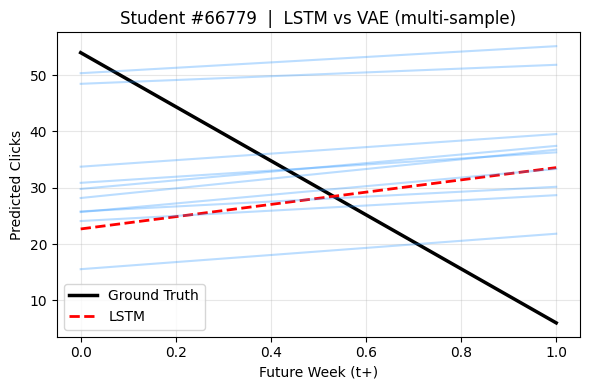

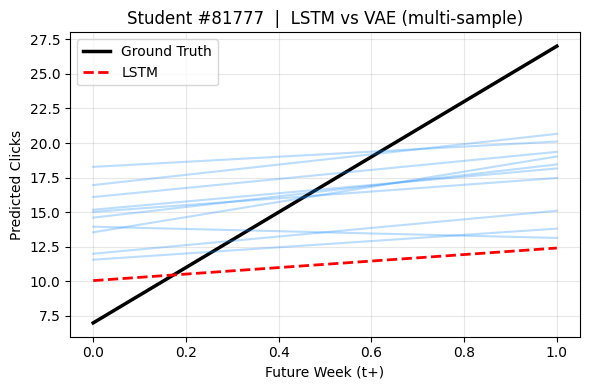

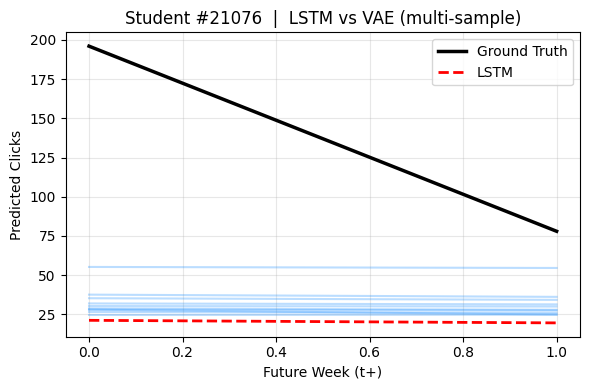

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

# ============================================================
# 🎨 可視化：LSTM vs VAE（多樣生成比較）
# ============================================================

def plot_comparison(lstm_pred, vae_samples, y_true, n_examples=3, n_vae_to_show=10):
    """
    🔹 功能：
        在同一張圖中比較：
          - Ground Truth（真實未來 clicks）
          - LSTM 預測（單一路徑）
          - VAE 多條隨機生成樣本

    🔹 輸入參數：
        lstm_pred       : Tensor (B, T_OUT, 1)，LSTM 預測結果
        vae_samples     : list of Tensor，每個元素為 (B, T_OUT, 1)
        y_true          : Tensor (B, T_OUT, 1)，真實標籤
        n_examples      : 要隨機顯示的學生樣本數
        n_vae_to_show   : 每位學生顯示幾條 VAE 曲線（可視化太多會雜亂）

    🔹 圖像顏色約定：
        - 黑線 (k-)      → Ground Truth（真實 clicks）
        - 紅虛線 (r--)   → LSTM 單一路徑預測
        - 淺藍線 (dodgerblue, α=0.3) → 多條 VAE 生成曲線
    """
    B = lstm_pred.size(0)
    # 隨機挑選 n_examples 位學生
    idxs = random.sample(range(B), n_examples)

    for i, idx in enumerate(idxs, 1):
        # 取出該學生的真實序列與預測結果
        gt = y_true[idx].cpu().numpy().flatten()       # 真實值
        lstm_y = lstm_pred[idx].cpu().numpy().flatten() # LSTM 預測

        plt.figure(figsize=(6, 4))

        # --- Ground Truth（黑實線） ---
        plt.plot(range(T_OUT), gt, 'k-', lw=2.5, label="Ground Truth")

        # --- LSTM 單一路徑（紅虛線） ---
        plt.plot(range(T_OUT), lstm_y, 'r--', lw=2.0, label="LSTM")

        # --- VAE 多樣生成樣本（藍色透明線） ---
        for k in range(min(n_vae_to_show, len(vae_samples))):
            yk = vae_samples[k][idx].cpu().numpy().flatten()
            plt.plot(range(T_OUT), yk, color='dodgerblue', alpha=0.3)

        # --- 視覺修飾 ---
        plt.title(f"Student #{idx}  |  LSTM vs VAE (multi-sample)")
        plt.xlabel("Future Week (t+)")
        plt.ylabel("Predicted Clicks")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


# ============================================================
# 🧪 範例執行
# ============================================================

plot_comparison(lstm_pred, vae_samples, y_true2, n_examples=3, n_vae_to_show=10)


In [ ]:
import torch
import pandas as pd
import numpy as np

# ============================================================
# 🧮 1) 準備資料張量（統一在 CPU）
# ============================================================
# 說明：
# - 把 LSTM / VAE / Ground Truth 都轉成 CPU 張量，方便後續用 numpy/pandas 分析。
# - y_true2 是測試集的真實 clicks。

y_true = y_true2  # 若變數名稱不同，改成 y_true2
P_lstm = lstm_pred.detach().cpu()     # (B, T_OUT, 1) → LSTM 預測
Y_true = y_true.detach().cpu()        # (B, T_OUT, 1) → 真實值
S_vae  = torch.stack(vae_samples, dim=0).detach().cpu()  # (N, B, T_OUT, 1) → N 條 VAE 樣本

B = P_lstm.size(0)  # 學生數量
N = S_vae.size(0)   # VAE 生成樣本數


# ============================================================
# 🧾 2) 每位學生的 MSE（原始尺度）
# ============================================================
# 功能：計算每位學生的預測誤差（LSTM vs VAE）
# - LSTM：單一路徑的平均平方誤差
# - VAE：N 條樣本分別計算 MSE，挑最好的那條 (Best-of-N)

mse_seq_lstm = ((P_lstm - Y_true) ** 2).mean(dim=(1, 2))                  # (B,)
mse_seq_vae_all = ((S_vae - Y_true.unsqueeze(0)) ** 2).mean(dim=(2, 3))   # (N, B)

# 對每位學生取出 VAE 最佳樣本（MSE 最小）
best_vals, best_idx = torch.min(mse_seq_vae_all, dim=0)  # (B,), (B,)
# Δ = LSTM - VAE_best（正值代表 VAE 較準）
delta = mse_seq_lstm - best_vals


# ============================================================
# 🌈 3) 每位學生的多樣性（Diversity）
# ============================================================
# 定義：VAE 在該學生上的生成序列之標準差（代表不確定性）
# 計算：在樣本維度上取 std，再對時間與通道平均。
# 結果：每位學生一個 scalar，越大代表多樣性越高。

div_seq = S_vae.std(dim=0).mean(dim=(1, 2))  # (B,)


# ============================================================
# 🔍 4) 匹配每位學生的真實 / LSTM / VAE_best 序列
# ============================================================
# 依照 best_idx 把每位學生的最佳 VAE 預測取出。
# 方便後續檢視具體例子（例如 Top-5 改善或退步）。

arange_B = torch.arange(B)
y_vae_best = S_vae[best_idx, arange_B, :, :]  # (B, T_OUT, 1)

# 將每條序列轉成 list 格式（便於輸出或 DataFrame 存放）
def row_to_list(x):
    return [float(v) for v in x.view(-1).tolist()]

rows = []
for i in range(B):
    rows.append({
        "idx":          int(i),
        "LSTM_MSE":     float(mse_seq_lstm[i].item()),
        "VAE_best_MSE": float(best_vals[i].item()),
        "Δ(LSTM−VAE)":  float(delta[i].item()),       # 改善量（正值表示 VAE 勝出）
        "y_true":       row_to_list(Y_true[i]),
        "y_LSTM":       row_to_list(P_lstm[i]),
        "y_VAE_best":   row_to_list(y_vae_best[i]),
        "Diversity_std": float(div_seq[i].item()),
    })

df = pd.DataFrame(rows)


# ============================================================
# ⚠️ 5) Top-5 退步案例（VAE 比 LSTM 差）
# ============================================================
# 從 Δ(LSTM−VAE) 取最小的五筆（即 VAE 預測最糟的學生）

top5_regressed = df.nsmallest(5, "Δ(LSTM−VAE)")
print("=== Top-5 Regressed（VAE best >> LSTM）===")
display(top5_regressed)


# ============================================================
# 📊 6) 依 Δ 分桶（Win-rate by Improvement Bucket）
# ============================================================
# 功能：將所有學生依據 Δ 值分群，統計 VAE 改善程度分布。
# 說明：
# - Δ = LSTM MSE − VAE best MSE
# - 若 Δ > 0 → 代表 VAE 比 LSTM 準（正值越大改善越多）
# - 若 Δ < 0 → 代表 VAE 比 LSTM 差

bins = [-np.inf, -1000, -200, -50, -10, 10, 50, 200, 1000, np.inf]  # 分桶邊界
labels = [
    "VAE<<劣(≪-1000)",
    "VAE劣(200~1000)",
    "VAE劣(50~200)",
    "VAE劣(10~50)",
    "≈打平(±10)",
    "VAE略勝(10~50)",
    "VAE勝(50~200)",
    "VAE大勝(200~1000)",
    "VAE>>大勝(≫1000)"
]

# 對 Δ 值分桶
bucket = pd.cut(df["Δ(LSTM−VAE)"], bins=bins, labels=labels, right=True)

# 統計每個區間的樣本數與比例
table = (
    bucket.value_counts()
    .reindex(labels)
    .fillna(0)
    .astype(int)
    .rename("count")
    .to_frame()
)
table["ratio"] = (table["count"] / len(df)).round(4)

print("\n=== Win-rate by improvement bucket（Δ = LSTM MSE − VAE best MSE） ===")
display(table)


=== Top-5 Regressed（VAE best >> LSTM）===


,idx,LSTM_MSE,VAE_best_MSE,Δ(LSTM−VAE),y_true,y_LSTM,y_VAE_best,Diversity_std
53195,53195,3.002442e+06,3.586380e+06,-583938.7500,"[3115.0, 1309.9998779296875]","[770.5662231445312, 596.8987426757812]","[565.771484375, 488.9063415527344]",6.056210
53194,53194,4.025990e+06,4.475906e+06,-449915.5000,"[1872.9998779296875, 3115.0]","[685.7081909179688, 537.7301635742188]","[513.9844970703125, 449.50030517578125]",9.820096
31808,31808,1.267695e+06,1.369916e+06,-102220.2500,"[2112.0, 64.0]","[579.0489501953125, 494.6407470703125]","[502.2989807128906, 449.6079406738281]",10.577400
12315,12315,1.530183e+05,2.433338e+05,-90315.4375,"[1064.0, 781.9999389648438]","[579.175048828125, 515.5765380859375]","[467.0916748046875, 420.93487548828125]",10.640914
53193,53193,1.856512e+06,1.939039e+06,-82526.5000,"[1271.9998779296875, 1872.9998779296875]","[222.31646728515625, 257.08221435546875]","[209.9903564453125, 214.62301635742188]",4.180231



=== Win-rate by improvement bucket（Δ = LSTM MSE − VAE best MSE） ===


,count,ratio
Δ(LSTM−VAE),,
VAE<<劣(≪-1000),648,0.0071
VAE劣(200~1000),1911,0.0209
VAE劣(50~200),4709,0.0514
VAE劣(10~50),4963,0.0542
≈打平(±10),4507,0.0492
VAE略勝(10~50),8980,0.0981
VAE勝(50~200),17641,0.1927
VAE大勝(200~1000),28645,0.3128
VAE>>大勝(≫1000),19562,0.2136
